## Intrusion Detection System Using XGBoost

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
data_train = pd.read_csv('UNSW_Training.csv')
data_test = pd.read_csv('UNSW_Testing.csv')

In [4]:
data_train.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS,UDP


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2934817 entries, 0 to 2934816
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   pkSeqID            int64  
 1   proto              object 
 2   saddr              object 
 3   sport              object 
 4   daddr              object 
 5   dport              object 
 6   seq                int64  
 7   stddev             float64
 8   N_IN_Conn_P_SrcIP  int64  
 9   min                float64
 10  state_number       int64  
 11  mean               float64
 12  N_IN_Conn_P_DstIP  int64  
 13  drate              float64
 14  srate              float64
 15  max                float64
 16  attack             int64  
 17  category           object 
 18  subcategory        object 
dtypes: float64(6), int64(6), object(7)
memory usage: 425.4+ MB


### Data Preprocessing

In [6]:
data_train.dtypes[data_train.dtypes=='object']

proto          object
saddr          object
sport          object
daddr          object
dport          object
category       object
subcategory    object
dtype: object

In [7]:
data_train['category'].value_counts()

DDoS              1541315
DoS               1320148
Reconnaissance      72919
Normal                370
Theft                  65
Name: category, dtype: int64

In [8]:
data_train.groupby(['category','subcategory']).count()

pkSeqID   proto   saddr   sport   daddr  \
category       subcategory                                                  
DDoS           HTTP                   786     786     786     786     786   
               TCP                 782228  782228  782228  782228  782228   
               UDP                 758301  758301  758301  758301  758301   
DoS            HTTP                  1184    1184    1184    1184    1184   
               TCP                 492615  492615  492615  492615  492615   
               UDP                 826349  826349  826349  826349  826349   
Normal         Normal                 370     370     370     370     370   
Reconnaissance OS_Fingerprint       14293   14293   14293   14293   14293   
               Service_Scan         58626   58626   58626   58626   58626   
Theft          Data_Exfiltration        6       6       6       6       6   
               Keylogging              59      59      59      59      59   

                                   dport     seq  stddev  N_IN_Conn_P_SrcIP  \
category       subcategory                                                    
DDoS           HTTP                  786     786     786                786   
               TCP                782228  782228  782228             782228   
               UDP                758301  758301  758301             758301   
DoS            HTTP                 1184    1184    1184               1184   
               TCP                492615  492615  492615             492615   
               UDP                826349  826349  826349             826349   
Normal         Normal                370     370     370                370   
Reconnaissance OS_Fingerprint      14293   14293   14293              14293   
               Service_Scan        58626   58626   58626              58626   
Theft          Data_Exfiltration       6       6       6                  6   
               Keylogging             59      59      59                 59   

                                     min  state_number    mean  \
category       subcategory                                       
DDoS           HTTP                  786           786     786   
               TCP                782228        782228  782228   
               UDP                758301        758301  758301   
DoS            HTTP                 1184          1184    1184   
               TCP                492615        492615  492615   
               UDP                826349        826349  826349   
Normal         Normal                370           370     370   
Reconnaissance OS_Fingerprint      14293         14293   14293   
               Service_Scan        58626         58626   58626   
Theft          Data_Exfiltration       6             6       6   
               Keylogging             59            59      59   

                                  N_IN_Conn_P_DstIP   drate   srate     max  \
category       subcategory                                                    
DDoS           HTTP                             786     786     786     786   
               TCP                           782228  782228  782228  782228   
               UDP                           758301  758301  758301  758301   
DoS            HTTP                            1184    1184    1184    1184   
               TCP                           492615  492615  492615  492615   
               UDP                           826349  826349  826349  826349   
Normal         Normal                           370     370     370     370   
Reconnaissance OS_Fingerprint                 14293   14293   14293   14293   
               Service_Scan                   58626   58626   58626   58626   
Theft          Data_Exfiltration                  6       6       6       6   
               Keylogging                        59      59      59      59   

                                  attack  
category       subcategory                
DDoS           HTTP            

In [9]:
data_train.groupby(['category'])['subcategory'].value_counts()

category        subcategory      
DDoS            TCP                  782228
                UDP                  758301
                HTTP                    786
DoS             UDP                  826349
                TCP                  492615
                HTTP                   1184
Normal          Normal                  370
Reconnaissance  Service_Scan          58626
                OS_Fingerprint        14293
Theft           Keylogging               59
                Data_Exfiltration         6
Name: subcategory, dtype: int64

In [10]:
#Merging category and subcategory into one column
data_train['target'] = data_train['category'] + "_" + data_train['subcategory']
data_train.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory,target
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS,UDP,DDoS_UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS,TCP,DDoS_TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS,TCP,DDoS_TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS,UDP,DoS_UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS,UDP,DDoS_UDP


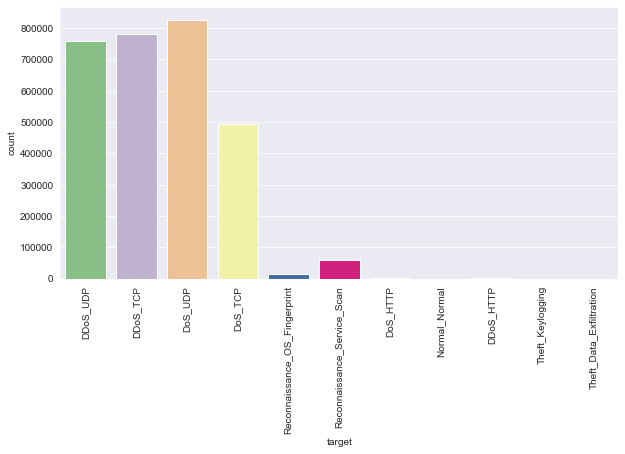

In [11]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.countplot(data_train['target'],palette='Accent')

In [12]:
#Merging category and subcategory into one column
data_test['target'] = data_test['category'] + "_" + data_test['subcategory']
data_test.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory,target
0,792371,udp,192.168.100.150,48516,192.168.100.3,80,175094,0.226784,100,4.100436,4,4.457383,100,0.000000,0.404711,4.719438,1,DoS,UDP,DoS_UDP
1,2056418,tcp,192.168.100.148,22267,192.168.100.3,80,143024,0.451998,100,3.439257,1,3.806172,100,0.225077,0.401397,4.442930,1,DDoS,TCP,DDoS_TCP
2,2795650,udp,192.168.100.149,28629,192.168.100.3,80,167033,1.931553,73,0.000000,4,2.731204,100,0.000000,0.407287,4.138455,1,DDoS,UDP,DDoS_UDP
3,2118009,tcp,192.168.100.148,42142,192.168.100.3,80,204615,0.428798,56,3.271411,1,3.626428,100,0.000000,0.343654,4.229700,1,DDoS,TCP,DDoS_TCP
4,303688,tcp,192.168.100.149,1645,192.168.100.5,80,40058,2.058381,100,0.000000,3,1.188407,100,0.000000,0.135842,4.753628,1,DoS,TCP,DoS_TCP


In [13]:
#Dropping Theft since it has very low values
indexNames = data_train[data_train['category']=='Theft'].index
data_train.drop(indexNames , inplace=True)

In [14]:
indexNames = data_test[data_test['category']=='Theft'].index
data_test.drop(indexNames , inplace=True)

In [15]:
data_train.drop(["pkSeqID","seq"], axis=1, inplace=True)
data_test.drop(["pkSeqID","seq"], axis=1, inplace=True)

In [16]:
data_train[data_train['category']=='Normal']

,proto,saddr,sport,daddr,dport,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory,target
3377,tcp,192.168.100.5,0,192.168.100.3,0,0.235357,7,0.598172,2,4.898582,7,0.000000,10.932437,4.999866,0,Normal,Normal,Normal_Normal
7683,udp,192.168.100.150,46295,192.168.217.2,53,0.000000,11,0.000000,4,0.000000,20,0.000000,0.400001,0.000000,0,Normal,Normal,Normal_Normal
8844,tcp,192.168.100.3,80,192.168.100.55,8080,0.228494,20,0.768694,2,4.947914,2,17.633553,17.634146,4.999863,0,Normal,Normal,Normal_Normal
10110,udp,192.168.100.147,38275,192.168.217.2,53,0.000000,18,0.000000,4,0.000000,18,0.000000,0.399866,0.000000,0,Normal,Normal,Normal_Normal
16479,udp,192.168.100.150,56155,255.255.255.255,3289,0.000000,14,0.000000,4,0.000000,2,0.000000,0.000000,0.000000,0,Normal,Normal,Normal_Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896922,udp,192.168.100.3,60946,192.31.80.30,53,0.000000,23,0.278547,2,0.278547,1,0.000000,0.000000,0.278547,0,Normal,Normal,Normal_Normal
2907572,ipv6-icmp,fe80::250:56ff:febe:c038,133,ff02::2,0,0.000000,1,0.000000,8,0.000000,3,0.000000,0.000000,0.000000,0,Normal,Normal,Normal_Normal
2912220,udp,192.168.100.4,60001,192.168.100.1,53,0.323125,7,0.000000,2,0.161776,4,0.555538,0.644334,0.808025,0,Normal,Normal,Normal_Normal
2917520,udp,192.168.100.148,41735,8.8.8.8,53,0.000000,20,0.007598,2,0.007598,15,0.000000,0.000000,0.007598,0,Normal,Normal,Normal_Normal


In [17]:
data_train['sport'].value_counts()

0x0303    7156
80        3220
1822       878
60541      869
1216       868
          ... 
27738       31
39305       30
18992       30
0x000d      10
0x0011       8
Name: sport, Length: 65541, dtype: int64

In [18]:
# converting Hexadecimal value to decimal in port number
check='0x'
s_res = set([i for i in data_train['sport'] if i.startswith(check)])
s_res

{'0x0008', '0x000d', '0x0011', '0x0303'}

In [19]:
data_train['sport']=data_train['sport'].replace(['0x0303'],'771') 
data_train['sport']=data_train['sport'].replace(['0x0011'],'17')
data_train['sport']=data_train['sport'].replace(['0x000d'],'13')
data_train['sport']=data_train['sport'].replace(['0x0008'],'8')

In [20]:
data_test['sport']=data_test['sport'].replace(['0x0303'],'771') 
data_test['sport']=data_test['sport'].replace(['0x0011'],'17')
data_test['sport']=data_test['sport'].replace(['0x000d'],'13')
data_test['sport']=data_test['sport'].replace(['0x0008'],'8')

In [21]:
data_train["sport"] = data_train["sport"].astype(str).astype(int)
data_test["sport"] = data_test["sport"].astype(str).astype(int)

In [22]:
check='0x'
d_res = set([i for i in data_train['dport'] if i.startswith(check)])
print(len(d_res))

1062


In [23]:
data_train["dport"] = data_train["dport"].apply(lambda x: int(x,16) if len(x)>1 and x[1]=="x" else int(x))
data_test["dport"] = data_test["dport"].apply(lambda x: int(x,16) if len(x)>1 and x[1]=="x" else int(x))

In [24]:
data_train['dport'].value_counts()

 80       2858794
 1           5379
 3306        3757
 53           275
-1            163
           ...   
 13445          1
 6636           1
 29153          1
 29152          1
 8863           1
Name: dport, Length: 6778, dtype: int64

In [25]:
# checking for negative port numbers
len(data_train[data_train['dport']<0]['dport'])

163

In [26]:
data_train[data_train['dport']==-1]['target'].value_counts()

Normal_Normal                    38
Reconnaissance_Service_Scan      34
Reconnaissance_OS_Fingerprint    26
DoS_UDP                          18
DoS_TCP                          17
DDoS_TCP                         15
DDoS_UDP                         10
DoS_HTTP                          5
Name: target, dtype: int64

In [27]:
#Since dport can't be negative, we are dropping it
indexNames = data_train[data_train['dport'] == -1].index
data_train.drop(indexNames, inplace=True)

In [28]:
data_test[data_test['dport']==-1]['target'].value_counts()

Reconnaissance_Service_Scan      12
Normal_Normal                     9
DoS_UDP                           6
DDoS_UDP                          6
Reconnaissance_OS_Fingerprint     6
DDoS_TCP                          3
DoS_TCP                           2
DoS_HTTP                          1
DDoS_HTTP                         1
Name: target, dtype: int64

In [29]:
indexNames = data_test[data_test['dport']==-1].index
data_test.drop(indexNames , inplace=True)

In [30]:
data_train.groupby(['category'])['subcategory'].value_counts()

category        subcategory   
DDoS            TCP               782213
                UDP               758291
                HTTP                 786
DoS             UDP               826331
                TCP               492598
                HTTP                1179
Normal          Normal               332
Reconnaissance  Service_Scan       58592
                OS_Fingerprint     14267
Name: subcategory, dtype: int64

In [31]:
data_train['target'].value_counts()

DoS_UDP                          826331
DDoS_TCP                         782213
DDoS_UDP                         758291
DoS_TCP                          492598
Reconnaissance_Service_Scan       58592
Reconnaissance_OS_Fingerprint     14267
DoS_HTTP                           1179
DDoS_HTTP                           786
Normal_Normal                       332
Name: target, dtype: int64

In [32]:
data_train.dtypes[data_train.dtypes=='object']

proto          object
saddr          object
daddr          object
category       object
subcategory    object
target         object
dtype: object

In [33]:
data_train.drop(["category","subcategory"], axis=1, inplace=True)
data_test.drop(["category","subcategory"], axis=1, inplace=True)

### Encoding Categorical columns

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_train["saddr_enc"]= le.fit_transform(data_train.saddr)
data_train["daddr_enc"]= le.fit_transform(data_train.daddr)
data_train["proto_enc"]= le.fit_transform(data_train.proto)
data_train["target_enc"]= le.fit_transform(data_train.target)

In [35]:
data_train.head()

,proto,saddr,sport,daddr,dport,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,target,saddr_enc,daddr_enc,proto_enc,target_enc
0,udp,192.168.100.150,6551,192.168.100.3,80,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS_UDP,3,14,3,2
1,tcp,192.168.100.150,5532,192.168.100.3,80,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS_TCP,3,14,2,1
2,tcp,192.168.100.147,27165,192.168.100.3,80,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS_TCP,0,14,2,1
3,udp,192.168.100.150,48719,192.168.100.3,80,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS_UDP,3,14,3,5
4,udp,192.168.100.147,22461,192.168.100.3,80,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS_UDP,0,14,3,2


In [36]:
# Dropping Redundant Columns
data_train.drop(['saddr','daddr','proto','target'], axis=1, inplace=True)

In [37]:
data_test["saddr_enc"]= le.fit_transform(data_test.saddr)
data_test["daddr_enc"]= le.fit_transform(data_test.daddr)
data_test["proto_enc"]= le.fit_transform(data_test.proto)
data_test["target_enc"]= le.fit_transform(data_test.target)
data_test.drop(['saddr','daddr','proto','target'], axis=1, inplace=True)

In [38]:
data_train['target_enc'].value_counts()

5    826331
1    782213
2    758291
4    492598
8     58592
7     14267
3      1179
0       786
6       332
Name: target_enc, dtype: int64

5 - DoS_UDP                          
1 - DDoS_TCP                         
2 - DDoS_UDP                         
4 - DoS_TCP                          
8 - Reconnaissance_Service_Scan       
7 - Reconnaissance_OS_Fingerprint     
3 - DoS_HTTP                           
0 - DDoS_HTTP                           
6 - Normal_Normal                       

### Scaling

In [39]:
y = data_train['target_enc']

In [40]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
features = data_train.iloc[:,:-1]
cols=features.columns
scaled_features= scaler.fit_transform(features)
data_train= pd.DataFrame(scaled_features,columns=cols)

In [41]:
data_train.head()

,sport,dport,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,saddr_enc,daddr_enc,proto_enc
0,-1.380968,-0.094032,1.260943,0.715432,-0.685675,0.729274,0.301061,0.415148,-0.00763,-0.003355,0.543937,0.010637,1.302349,-0.643845,0.898098
1,-1.434281,-0.094032,-1.006704,-1.827146,1.914094,-0.113134,1.122958,0.415148,-0.00763,-0.003659,0.533890,0.010637,1.302349,-0.643845,-1.050938
2,-0.302458,-0.094032,-0.769453,0.715432,1.319021,-0.113134,0.731911,0.415148,-0.00763,-0.003610,0.316934,0.010637,-1.281797,-0.643845,-1.050938
3,0.825232,-0.094032,1.164907,-0.801913,-0.685675,0.729274,0.653770,-1.622798,-0.00763,-0.003397,1.033331,0.010637,1.302349,-0.643845,0.898098
4,-0.548568,-0.094032,-0.080394,0.715432,1.322995,0.729274,1.154778,0.415148,-0.00763,-0.002707,1.061356,0.010637,-1.281797,-0.643845,0.898098


In [42]:
ytest = data_test['target_enc']
features = data_test.iloc[:,:-1]
cols=features.columns
scaled_features= scaler.fit_transform(features)
data_test= pd.DataFrame(scaled_features,columns=cols)

In [43]:
data_test.head()

,sport,dport,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,saddr_enc,daddr_enc,proto_enc
0,0.815980,-0.094347,-0.822350,0.716722,2.076170,0.728973,1.465443,0.415659,-0.006811,-0.004605,0.911656,0.011558,1.303394,-0.667508,0.896919
1,-0.556663,-0.094347,-0.542236,0.716722,1.630704,-1.799696,1.036313,0.415659,-0.003783,-0.004613,0.763047,0.011558,-0.422688,-0.667508,-1.051749
2,-0.223974,-0.094347,1.297989,-0.388902,-0.686481,0.728973,0.327939,0.415659,-0.006811,-0.004599,0.599406,0.011558,0.440353,-0.667508,0.896919
3,0.482664,-0.094347,-0.571091,-1.085035,1.517618,-1.799696,0.917867,0.415659,-0.006811,-0.004757,0.648446,0.011558,-0.422688,-0.667508,-1.051749
4,-1.635053,-0.094347,1.455734,0.716722,-0.686481,-0.113916,-0.688722,0.415659,-0.006811,-0.005272,0.930031,0.011558,0.440353,0.636049,-1.051749


In [44]:
y.value_counts()

5    826331
1    782213
2    758291
4    492598
8     58592
7     14267
3      1179
0       786
6       332
Name: target_enc, dtype: int64

In [45]:
x = data_train
xtest = data_test

### Sampling

In [46]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
samp_strat= {5:70000, 1:70000, 2:70000, 4:65000, 8:58592, 7:14267, 3:1179, 0:786, 6:332}
random_under= RandomUnderSampler(sampling_strategy=samp_strat,random_state=1)
X_rus,y_rus = random_under.fit_resample(x,y)

In [47]:
y_rus.value_counts()

5    70000
2    70000
1    70000
4    65000
8    58592
7    14267
3     1179
0      786
6      332
Name: target_enc, dtype: int64

In [48]:
from imblearn.over_sampling import RandomOverSampler
samp_strat= {5:70000, 1:70000, 2:70000, 4:65000, 8:58592, 7:30000, 3:20000, 0:15000, 6:8000}
random_under= RandomOverSampler(sampling_strategy=samp_strat,random_state=1)
Xres,yres = random_under.fit_resample(X_rus,y_rus)

In [49]:
yres.value_counts()

5    70000
2    70000
1    70000
4    65000
8    58592
7    30000
3    20000
0    15000
6     8000
Name: target_enc, dtype: int64

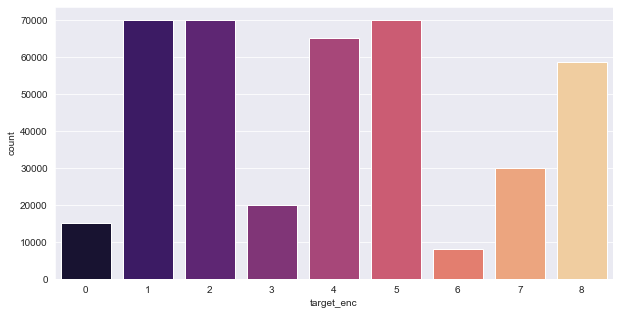

In [50]:
plt.figure(figsize=(10,5))
sns.countplot(yres,palette='magma')

### XGBoost Model

In [51]:
from sklearn import model_selection

In [52]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xres,yres, test_size=0.20, random_state=42, stratify=yres)

In [54]:
import time
start = time.time()

from xgboost import XGBClassifier
model_1 = XGBClassifier(random_state = 42)
model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_test)
score_1 = model_1.score(X_test,y_test)

end = time.time()

print("Time taken: ",end - start, "seconds")
print("Accuracy of base model: ",score_1)

Time taken:  78.64123201370239 seconds
Accuracy of base model:  0.9998401357616301


In [55]:
pd.Series(pred_1).value_counts()

5    14000
2    14000
1    13993
4    13006
8    11715
7     6004
3     4000
0     3001
6     1600
dtype: int64

In [56]:
from sklearn.metrics import classification_report,confusion_matrix, multilabel_confusion_matrix
print(classification_report(y_test,pred_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00     14000
           2       1.00      1.00      1.00     14000
           3       1.00      1.00      1.00      4000
           4       1.00      1.00      1.00     13000
           5       1.00      1.00      1.00     14000
           6       1.00      1.00      1.00      1600
           7       1.00      1.00      1.00      6000
           8       1.00      1.00      1.00     11719

    accuracy                           1.00     81319
   macro avg       1.00      1.00      1.00     81319
weighted avg       1.00      1.00      1.00     81319



In [57]:
confusion_matrix(y_test,pred_1)

array([[ 3000,     0,     0,     0,     0,     0,     0,     0,     0],
       [    1, 13993,     0,     0,     6,     0,     0,     0,     0],
       [    0,     0, 14000,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,  4000,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0, 13000,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0, 14000,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,  1600,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,  5999,     1],
       [    0,     0,     0,     0,     0,     0,     0,     5, 11714]],
      dtype=int64)

In [58]:
multilabel_confusion_matrix(y_test,pred_1)

array([[[78318,     1],
        [    0,  3000]],

       [[67319,     0],
        [    7, 13993]],

       [[67319,     0],
        [    0, 14000]],

       [[77319,     0],
        [    0,  4000]],

       [[68313,     6],
        [    0, 13000]],

       [[67319,     0],
        [    0, 14000]],

       [[79719,     0],
        [    0,  1600]],

       [[75314,     5],
        [    1,  5999]],

       [[69599,     1],
        [    5, 11714]]], dtype=int64)

In [59]:
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score

In [60]:
#K-Fold CV
model_1 = XGBClassifier(random_state = 42)
model_1.fit(X_train, y_train)
score_1 = cross_val_score(model_1, X_train, y_train)

In [63]:
print("Cross Validation score: ",np.mean(score_1))

Cross Validation score:  0.9998186141201597


In [64]:
pred_2 = model_1.predict(xtest)
score_2 = model_1.score(xtest,ytest)
print("Accuracy of test model: ",score_2)

Accuracy of test model:  0.7929720777760361


#### Hyper parameter tuning


In [65]:
model_2 = XGBClassifier(random_state = 42, learning_rate = 0.3,
                        max_depth = 5, n_estimators = 500, subsample = 0.6)
model_2.fit(X_train, y_train)
pred_3 = model_2.predict(X_test)
score_4 = model_2.score(X_test,y_test)
print("Accuracy of tuned model 1: ",score_4)

Accuracy of tuned model 1:  0.9999139192562624


In [66]:
pred_4 = model_2.predict(xtest)
score_5 = model_2.score(xtest,ytest)
print("Accuracy of test model 1: ",score_5)

Accuracy of test model 1:  0.9100177878946902


In [67]:
model_3 = XGBClassifier(random_state = 42, learning_rate = 0.2,
                        max_depth = 5, n_estimators = 200, subsample = 0.5)
model_3.fit(X_train, y_train)
pred_5 = model_3.predict(X_test)
score_6 = model_3.score(X_test,y_test)
print("Accuracy of tuned model 2: ",score_6)

Accuracy of tuned model 2:  0.9998524330107355


In [68]:
pred_6 = model_3.predict(xtest)
score_7 = model_3.score(xtest,ytest)
print("Accuracy of test model 2: ",score_7)

Accuracy of test model 2:  0.8711583940461668


In [69]:
model_4 = XGBClassifier(random_state = 42, learning_rate = 0.1,
                        max_depth = 4, n_estimators = 300, subsample = 0.7)
model_4.fit(X_train, y_train)
pred_7 = model_4.predict(X_test)
score_8 = model_4.score(X_test,y_test)
print("Accuracy of tuned model 3: ",score_8)

Accuracy of tuned model 3:  0.999803244014314


In [71]:
pred_8 = model_4.predict(xtest)
score_9 = model_4.score(xtest,ytest)
print("Accuracy of test model 3: ",score_9)

Accuracy of test model 3:  0.9224856708626107


In [72]:
model_5 = XGBClassifier(random_state = 42, learning_rate = 0.2,
                        max_depth = 5, n_estimators = 300, subsample = 0.7)
model_5.fit(X_train, y_train)
pred_9 = model_5.predict(X_test)
score_10 = model_5.score(X_test,y_test)
print("Accuracy of tuned model 4: ",score_10)

Accuracy of tuned model 4:  0.9998524330107355


In [73]:
pred_10 = model_5.predict(xtest)
score_11 = model_5.score(xtest,ytest)
print("Accuracy of test model 4: ",score_11)

Accuracy of test model 3:  0.8641468285069754


### Results

In [98]:
print("Results of various Parameter tuned models ")
print("")
print("Train model 0: ",round(np.mean(score_1)*100,2),"%")
print("Test model 0: ",round(score_2*100,2),"%")
print("")
print("Train model 1: ",round(score_4*100,2),"%")
print("Test model 1: ",round(score_5*100,2),"%")
print("")
print("Train model 2: ",round(score_6*100,2),"%")
print("Test model 2: ",round(score_7*100,2),"%")
print("")
print("Train model 3: ",round(score_8*100,2),"%")
print("Test model 3: ",round(score_9*100,2),"%")
print("")
print("Train model 4: ",round(score_10*100,2),"%")
print("Test model 4: ",round(score_11*100,2),"%")

Results of various Parameter tuned models 

Train model 0:  99.98 %
Test model 0:  79.3 %

Train model 1:  99.99 %
Test model 1:  91.0 %

Train model 2:  99.99 %
Test model 2:  87.12 %

Train model 3:  99.98 %
Test model 3:  92.25 %

Train model 4:  99.99 %
Test model 4:  86.41 %


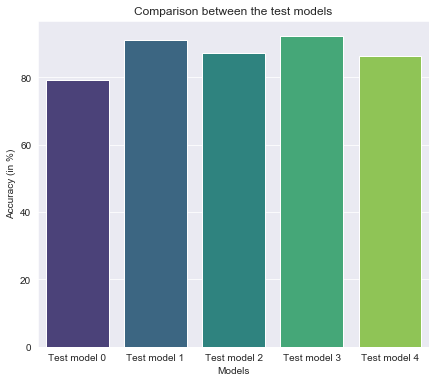

In [80]:
plt.figure(figsize=(7,6))
results = [score_2*100,score_5*100,score_7*100,score_9*100,score_11*100]
model_names = ['Test model 0','Test model 1','Test model 2','Test model 3','Test model 4']
sns.barplot(x = model_names, y=results, palette='viridis')
plt.xlabel('Models')
plt.ylabel('Accuracy (in %)')
plt.title('Comparison between the test models')
plt.show()

Test Model 3 has the best accuracy among all the other models.  
**Best Parameters are:**   
learning_rate = 0.1,  
max_depth = 4,  
n_estimators = 300,  
subsample = 0.7

#### Base Model

In [81]:
multilabel_confusion_matrix(y_test,pred_1)

array([[[78318,     1],
        [    0,  3000]],

       [[67319,     0],
        [    7, 13993]],

       [[67319,     0],
        [    0, 14000]],

       [[77319,     0],
        [    0,  4000]],

       [[68313,     6],
        [    0, 13000]],

       [[67319,     0],
        [    0, 14000]],

       [[79719,     0],
        [    0,  1600]],

       [[75314,     5],
        [    1,  5999]],

       [[69599,     1],
        [    5, 11714]]], dtype=int64)

In [97]:
cf = confusion_matrix(y_test,pred_1)
label = ['DDoS_HTTP','DDoS_TCP','DDoS_UDP','DoS_HTTP','DoS_TCP','DoS_UDP',
          'Normal_Normal','OS_Fingerprint','Service_Scan']
cfm = pd.DataFrame(cf,index=label,columns=label)
cfm

,DDoS_HTTP,DDoS_TCP,DDoS_UDP,DoS_HTTP,DoS_TCP,DoS_UDP,Normal_Normal,OS_Fingerprint,Service_Scan
DDoS_HTTP,3000,0,0,0,0,0,0,0,0
DDoS_TCP,1,13993,0,0,6,0,0,0,0
DDoS_UDP,0,0,14000,0,0,0,0,0,0
DoS_HTTP,0,0,0,4000,0,0,0,0,0
DoS_TCP,0,0,0,0,13000,0,0,0,0
DoS_UDP,0,0,0,0,0,14000,0,0,0
Normal_Normal,0,0,0,0,0,0,1600,0,0
OS_Fingerprint,0,0,0,0,0,0,0,5999,1
Service_Scan,0,0,0,0,0,0,0,5,11714


In [99]:
print(classification_report(y_test,pred_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00     14000
           2       1.00      1.00      1.00     14000
           3       1.00      1.00      1.00      4000
           4       1.00      1.00      1.00     13000
           5       1.00      1.00      1.00     14000
           6       1.00      1.00      1.00      1600
           7       1.00      1.00      1.00      6000
           8       1.00      1.00      1.00     11719

    accuracy                           1.00     81319
   macro avg       1.00      1.00      1.00     81319
weighted avg       1.00      1.00      1.00     81319



**Inferences from the report:**   
 The training model has given very high values of recall and precision thus indicating to very good fit on the training dataset.

#### Tuned Model

In [95]:
ytest.value_counts()

5    206620
1    195149
2    189948
4    123183
8     14530
7      3615
3       300
0       202
6        98
Name: target_enc, dtype: int64

In [84]:
#Test Model: 3
multilabel_confusion_matrix(ytest,pred_8)

array([[[733327,    116],
        [     0,    202]],

       [[538459,     37],
        [  5372, 189777]],

       [[543695,      2],
        [  3466, 186482]],

       [[732923,    422],
        [     1,    299]],

       [[608916,   1546],
        [ 46549,  76634]],

       [[523560,   3465],
        [     4, 206616]],

       [[733547,      0],
        [     0,     98]],

       [[702172,  27858],
        [  1466,   2149]],

       [[695693,  23422],
        [    10,  14520]]], dtype=int64)

In [94]:
conf = confusion_matrix(ytest,pred_8)
label = ['DDoS_HTTP','DDoS_TCP','DDoS_UDP','DoS_HTTP','DoS_TCP','DoS_UDP',
          'Normal_Normal','OS_Fingerprint','Service_Scan']
cm = pd.DataFrame(conf,index=label,columns=label)
cm

,DDoS_HTTP,DDoS_TCP,DDoS_UDP,DoS_HTTP,DoS_TCP,DoS_UDP,Normal_Normal,OS_Fingerprint,Service_Scan
DDoS_HTTP,202,0,0,0,0,0,0,0,0
DDoS_TCP,70,189777,0,36,1544,0,0,89,3633
DDoS_UDP,0,0,186482,0,0,3465,0,1,0
DoS_HTTP,0,0,0,299,0,0,0,0,1
DoS_TCP,46,32,0,386,76634,0,0,27759,18326
DoS_UDP,0,0,2,0,0,206616,0,2,0
Normal_Normal,0,0,0,0,0,0,98,0,0
OS_Fingerprint,0,2,0,0,2,0,0,2149,1462
Service_Scan,0,3,0,0,0,0,0,7,14520


In [89]:
print(classification_report(ytest,pred_8))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       202
           1       1.00      0.97      0.99    195149
           2       1.00      0.98      0.99    189948
           3       0.41      1.00      0.59       300
           4       0.98      0.62      0.76    123183
           5       0.98      1.00      0.99    206620
           6       1.00      1.00      1.00        98
           7       0.07      0.59      0.13      3615
           8       0.38      1.00      0.55     14530

    accuracy                           0.92    733645
   macro avg       0.72      0.91      0.75    733645
weighted avg       0.97      0.92      0.94    733645



**Inferences from the report:**   
The testing model has given mixed values for different classes present in the target column. However, overall average recall was found out to be 0.92, i.e. 92% and a precision of 97%.